In [9]:
import pandas as pd
import wandb
import pandas as pd
import ast
import glob
import numpy as np
import warnings
from datetime import date
from collections import defaultdict

today = date.today()
api = wandb.Api()

# # Find all csv files in the current directory
csv_files = glob.glob("*.csv")
# # Collect all the names of the csv files without the extension
csv_names = [csv_file[:-4] for csv_file in csv_files]
project_name = "topobenchmark_0503"  #'best_results_edhnn'
user = "telyatnikov_sap"

if project_name not in csv_names:
    runs = api.runs(f"{user}/{project_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k, v in run.config.items() if not k.startswith("_")}
        )

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame(
        {"summary": summary_list, "config": config_list, "name": name_list}
    )

    runs_df.to_csv(f"{project_name}.csv")
else:
    runs_df = pd.read_csv(f"{project_name}.csv", index_col=0)

    for row in runs_df.iloc:
        row["summary"] = ast.literal_eval(row["summary"])
        row["config"] = ast.literal_eval(row["config"])


for row in runs_df.iloc:
    row["summary"].update(row["config"])

lst = [i["summary"] for i in runs_df.iloc]
df = pd.DataFrame.from_dict(lst)

df_init = df.copy()

# Get average epoch run time
df["epoch_run_time"] = df["_runtime"] / df["epoch"]

In [10]:
df_init["model"].apply(lambda x: x)

0        {'loss': {'task': 'classification', '_target_'...
1        {'loss': {'task': 'classification', '_target_'...
2        {'loss': {'task': 'classification', '_target_'...
3        {'loss': {'task': 'classification', '_target_'...
4        {'loss': {'task': 'classification', '_target_'...
5        {'loss': {'task': 'classification', '_target_'...
6        {'loss': {'task': 'classification', '_target_'...
7        {'loss': {'task': 'classification', '_target_'...
8        {'loss': {'task': 'classification', '_target_'...
9        {'loss': {'task': 'classification', '_target_'...
10       {'loss': {'task': 'classification', '_target_'...
11       {'loss': {'task': 'classification', '_target_'...
12       {'loss': {'task': 'classification', '_target_'...
13       {'loss': {'task': 'classification', '_target_'...
14       {'loss': {'task': 'classification', '_target_'...
15       {'loss': {'task': 'classification', '_target_'...
16       {'loss': {'task': 'classification', '_target_'.

In [11]:
def normalize_column(df, column_to_normalize):
    # Use json_normalize to flatten the nested dictionaries into separate columns
    flattened_df = pd.json_normalize(df[column_to_normalize])
    # Rename columns to include 'nested_column' prefix
    flattened_df.columns = [
        f"{column_to_normalize}.{col}" for col in flattened_df.columns
    ]
    # Concatenate the flattened DataFrame with the original DataFrame
    result_df = pd.concat([df, flattened_df], axis=1)
    # Get new columns names
    new_columns = flattened_df.columns
    # Drop the original nested column if needed
    result_df.drop(column_to_normalize, axis=1, inplace=True)
    return result_df, new_columns


# Config columns to normalize
columns_to_normalize = ["model", "dataset", "callbacks"]

# Keep track of config columns added
config_columns = []
for column in columns_to_normalize:
    df, columns = normalize_column(df, column)
    config_columns.extend(columns)

In [12]:
# Remove columns that are not needed (we shouldn't vary them or their variation is not interesting)
remove_col = [
    "dataset.transforms.data_manipulations.selected_fields",
    "callbacks.model_checkpoint.dirpath",
]
df = df.drop(remove_col, axis=1)

# Ensure that removed columns are not present in config_columns
config_columns = [col for col in config_columns if col != remove_col]

In [13]:
print(
    f"Number of rows with model.backbone._target_ = nan is {sum(df['model.backbone._target_'].isna())}"
)
# Drop na values if there are
df = df.dropna(subset=["model.backbone._target_"])
# Reset index
df = df.reset_index(drop=True)

# Drop rows that 'callbacks.early_stopping.monitor' isna
print(
    f"Number of rows with callbacks.early_stopping.monitor = nan is {sum(df['callbacks.early_stopping.monitor'].isna())}"
)
print("Because of SCCN and CWN false runs there were 96 such runs on 13/03/24")
df = df.dropna(subset=["callbacks.early_stopping.monitor"])
# Reset index
df = df.reset_index(drop=True)


# Get correct names for the models
df["model.backbone._target_"] = df["model.backbone._target_"].apply(
    lambda x: x.split(".")[-1]
)

Number of rows with model.backbone._target_ = nan is 4
Number of rows with callbacks.early_stopping.monitor = nan is 0
Because of SCCN and CWN false runs there were 96 such runs on 13/03/24


In [14]:
df["model.backbone._target_"].unique()

array(['SCCNNCusctom', 'SCCN', 'SCCNN', 'CWNDCM', 'CWN', 'GCN', 'AllSet',
       'UniGCNII', 'EDGNN', 'GIN'], dtype=object)

In [15]:
# Identify unique models in DataFrame
unique_models = df["model.backbone._target_"].unique()

# Identify unique datasets in DataFrame
unique_datasets = df["dataset.parameters.data_name"].unique()


collected_results = defaultdict(dict)
collected_aggregated_results = defaultdict(dict)
collected_non_aggregated_results = defaultdict(dict)
# Got over each dataset and model and find the best result
for dataset in unique_datasets:
    for model in unique_models:
        # Get the subset of the DataFrame for the current dataset and model
        subset = df[
            (df["dataset.parameters.data_name"] == dataset)
            & (df["model.backbone._target_"] == model)
        ]

        if subset.empty:
            print(f"---------")
            print(f"No results for {model} on {dataset}")
            print(f"---------")
            continue
        # Suppress all warnings
        warnings.filterwarnings("ignore")
        subset["Model"] = model
        warnings.filterwarnings("default")

        def get_metric(df):
            metric_ = df["callbacks.early_stopping.monitor"].unique()
            assert len(metric_) == 1, "There should be only one metric to optimize"
            metric = metric_[0]
            return metric.split("/")[-1]

        # Cols to get statistics later
        # TODO: log maximum validation value for optimized metric
        performance_cols = [f"test/{get_metric(subset)}"]

        # Get the unique values for each config column
        unique_colums_values = {}
        for col in config_columns:
            try:
                unique_colums_values[col] = subset[col].unique()
            except:
                print(f"Attention the columns: {col}, has issues with unique values")

        # Keep only those keys that have more than one unique value
        unique_colums_values = {
            k: v for k, v in unique_colums_values.items() if len(v) > 1
        }

        # Print the unique values for each config column

        print(f"Unique values for each config column for {model} on {dataset}:")
        for col, unique in unique_colums_values.items():
            print(f"{col}: {unique}")
            print()
        print(f"---------")

        # Check if "special colums" are not in unique_colums_values
        # For example dataset.parameters.data_seed should not be in aggregation columns
        # If it is, then we should remove it from the list
        special_columns = ["dataset.parameters.data_seed"]

        for col in special_columns:
            if col in unique_colums_values:
                unique_colums_values.pop(col)

        # Obtain the aggregation columns
        aggregation_columns = ["Model"] + list(unique_colums_values.keys())

        collected_non_aggregated_results[dataset][model] = {
            "df": subset.copy(),
            "aggregation_columns": aggregation_columns,
            "performance_cols": performance_cols,
        }

        # Aggregate the subset by the aggregation columns and get the best result for each group
        aggregated = subset.groupby(aggregation_columns).agg(
            {col: ["mean", "std"] for col in performance_cols}
        )

        # Go from MultiIndex to Index
        aggregated = aggregated.reset_index()

        assert (
            len(subset["callbacks.early_stopping.mode"].unique()) == 1
        ), "There should be only one mode for early stopping"
        # Identify the mode of the early stopping mode

        if subset["callbacks.early_stopping.mode"].unique()[0] == "max":
            ascending = False
            final_best_ = aggregated.sort_values(
                by=(f"test/{get_metric(subset)}", "mean"), ascending=ascending
            ).head(1)
            final_best_ = (final_best_ * 100).round(2)
        else:
            ascending = True
            final_best_ = aggregated.sort_values(
                by=(f"test/{get_metric(subset)}", "mean"), ascending=ascending
            ).head(1)

        collected_results[dataset][model] = {
            "mean": final_best_[(f"test/{get_metric(subset)}", "mean")].values[0],
            "std": final_best_[(f"test/{get_metric(subset)}", "std")].values[0],
        }
        collected_aggregated_results[dataset][model] = aggregated.sort_values(
            by=(f"test/{get_metric(subset)}", "mean"), ascending=ascending
        )

Attention the columns: model.backbone.in_channels_all, has issues with unique values
Attention the columns: model.backbone.hidden_channels_all, has issues with unique values
Attention the columns: model.feature_encoder.in_channels, has issues with unique values
Attention the columns: model.feature_encoder.selected_dimensions, has issues with unique values
Attention the columns: dataset.transforms.data_manipulations.selected_fields, has issues with unique values
Attention the columns: callbacks.model_checkpoint.dirpath, has issues with unique values
Unique values for each config column for SCCNNCusctom on NCI1:
model.readout.pooling_type: ['mean' 'sum']

model.backbone.n_layers: [2. 1.]

model.backbone_wrapper.wrapper_readout: ['signal_prop_down' 'original']

dataset.parameters.data_seed: [5. 3. 0.]

dataset.transforms.graph2simplicial_lifting.signed: [False True]

---------
Attention the columns: model.feature_encoder.in_channels, has issues with unique values
Attention the columns: da

In [16]:
# collected_aggregated_results['ZINC']['SCCN']
a = collected_non_aggregated_results['ZINC']['SCCN']['df']
aggregation_columns = collected_non_aggregated_results['ZINC']['SCCN']['aggregation_columns']
performance_cols = collected_non_aggregated_results['ZINC']['SCCN']['performance_cols']

#a = a[(a['dataset.transforms.graph2simplicial_lifting.feature_lifting'] =='set') | (a['dataset.transforms.graph2simplicial_lifting.feature_lifting'] =='concatenation')]
a['dataset.transforms.graph2simplicial_lifting.feature_lifting'][a['dataset.transforms.graph2simplicial_lifting.feature_lifting'].isna()] = 'projection'
a = a[~a['test/mae'].isna()]

a = a.groupby(aggregation_columns +['dataset.transforms.graph2simplicial_lifting.feature_lifting', 'model.feature_encoder._target_', 'model.backbone_wrapper.wrapper_readout']).agg(
            {col: ["mean", "std"] for col in performance_cols}
        )

ascending = True
a = a.sort_values(
    by=(f"test/mae", "mean"), ascending=ascending
)
# Show all rows
pd.set_option('display.max_rows', None)

a

/tmp/ipykernel_195800/1089313772.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  a['dataset.transforms.graph2simplicial_lifting.feature_lifting'][a['dataset.transforms.graph2simplicial_lifting.feature_lifting'].isna()] = 'projection'
/tm

test/mae  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          mean   
Model model.readout.in_channels model.readout.pooling_type model.backbone.n_layers model.feature_encoder._target_                     model.feature_encoder.out_channels model.backbone_wrapper.out_channels model.backbone_wrapper.wrapper_readout model.backbone.channels model.backbone.max_rank dataset.parameters.batch_size dataset.transforms.graph2simplicial_lifting.signed dataset.transforms.graph2simplicial_lifting.fea... dataset.transforms.graph2simplicial_lifting.fea... model.feature_encoder._target_                     model.backbone_wrapper.wrapper_readout             
SCCN  16.0                      mean                       4.0                     topobenchmarkx.models.encoders.default_encoders... 16.0                               16.0                                signal_prop_down                       16.0                    1.0                     128.0                         False                                              concatenation                                      concatenation                                      topobenchmarkx.models.encoders.default_encoders... signal_prop_down                        0.522612   
      64.0                      mean                       4.0                     topobenchmarkx.models.encoders.default_encoders... 64.0                               64.0                                original                               64.0                    1.0                     128.0                         True                                               projection                                         projection                                         topobenchmarkx.models.encoders.default_encoders... original                                0.538129   
                                                                                                                                                                                                                                                                                                                                                                                     concatenation                                      concatenation                                      topobenchmarkx.models.encoders.default_encoders... original                                0.541560   
      16.0                      sum                        4.0                     topobenchmarkx.models.encoders.default_encoders... 16.0                               16.0                                original                               16.0                    1.0                     128.0                         False                                              projection                                         projection                                         topobenchmarkx.models.encoders.default_encoders... original                                0.563449   
                                                                                                                                                                                                             signal_prop_down                       16.0                    1.0                     128.0                         False                                              concatenation                                      concatenation                                      topobenchmarkx.models.encoders.default_encode

In [28]:
# collected_aggregated_results['ZINC']['SCCN']
dataset = 'NCI1'
model = 'SCCNN'
a = collected_non_aggregated_results[dataset][model]['df']
aggregation_columns = collected_non_aggregated_results[dataset][model]['aggregation_columns']
performance_cols = collected_non_aggregated_results[dataset][model]['performance_cols']

#a = a[(a['dataset.transforms.graph2simplicial_lifting.feature_lifting'] =='set') | (a['dataset.transforms.graph2simplicial_lifting.feature_lifting'] =='concatenation')]
a['dataset.transforms.graph2simplicial_lifting.feature_lifting'][a['dataset.transforms.graph2simplicial_lifting.feature_lifting'].isna()] = 'projection'

if 'mae' in performance_cols:
    a = a[~a['test/mae'].isna()]
else:
    pass

a = a.groupby(aggregation_columns +['dataset.transforms.graph2simplicial_lifting.feature_lifting', 'model.feature_encoder._target_', 'model.backbone_wrapper.wrapper_readout']).agg(
            {col: ["mean", "std"] for col in performance_cols}
        )

if 'mae' in performance_cols:
    ascending = True
    a = a.sort_values(
        by=(f"test/mae", "mean"), ascending=ascending
    )
else: 
    ascending = False
    a = a.sort_values(
        by=(f"test/mae", "mean"), ascending=ascending
    )
# Show all rows
pd.set_option('display.max_rows', None)

a

/tmp/ipykernel_195800/820759529.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  a['dataset.transforms.graph2simplicial_lifting.feature_lifting'][a['dataset.transforms.graph2simplicial_lifting.feature_lifting'].isna()] = 'projection'
/tmp

KeyError: ('test/mae', 'mean')

In [29]:
aggregation_columns

['Model',
 'model.readout.in_channels',
 'model.readout.pooling_type',
 'model.backbone.n_layers',
 'model.feature_encoder.out_channels',
 'model.backbone_wrapper.out_channels',
 'model.backbone_wrapper.wrapper_readout',
 'dataset.transforms.graph2simplicial_lifting.signed']

['test/accuracy']

['test/accuracy']

Empty DataFrame
Columns: [(test/accuracy, mean), (test/accuracy, std)]
Index: []

In [9]:
# a = list(collected_aggregated_results['ZINC']['SCCNN']['dataset.parameters.batch_size'])[:10]
# # Print the proportion of unique values
# a, b = np.unique(a, return_counts=True)
# print(f'Lr values:{a[0]}, prop_counts: {b[0]/sum(b)}',)
# print(f'Lr values:{a[1]}, prop_counts: {b[1]/sum(b)}',)

In [10]:
# collected_aggregated_results['ZINC']['SCCN']

In [11]:
# Convert nested dictionary to DataFrame
nested_dict = dict(collected_results)
result_dict = pd.DataFrame.from_dict(
    {
        (i, j): nested_dict[i][j]
        for i in nested_dict.keys()
        for j in nested_dict[i].keys()
    },
    orient="index",
)


result_dict = result_dict.round(2)
result_dict["performance"] = result_dict.apply(
    lambda x: f"{x['mean']} ± {x['std']}", axis=1
)
result_dict = result_dict.drop(["mean", "std"], axis=1)

# Reset multiindex
result_dict = result_dict.reset_index()
# rename columns
result_dict.columns = ["Dataset", "Model", "Performance"]

In [12]:
result_dict.pivot_table(
    index="Model", columns="Dataset", values="Performance", aggfunc="first"
)

Dataset,Cora,IMDB-BINARY,IMDB-MULTI,MUTAG,NCI1,PROTEINS,PubMed,REDDIT-BINARY,ZINC,citeseer
Model,,,,,,,,,,
AllSet,89.05 ± 0.56,80.0 ± 2.65,52.89 ± 2.04,92.59 ± 3.21,80.7 ± 0.85,81.6 ± 4.56,88.12 ± 0.2,75.0 ± 1.41,NaN,75.28 ± 1.83
CWN,88.56 ± 1.95,NaN,NaN,nan ± nan,77.86 ± nan,78.73 ± 4.32,87.53 ± 0.5,NaN,0.45 ± nan,75.48 ± 1.76
CWNDCM,89.42 ± 1.89,NaN,NaN,85.19 ± 8.49,75.51 ± 1.62,NaN,87.61 ± 0.72,NaN,0.79 ± nan,75.58 ± 0.46
EDGNN,90.16 ± 0.43,78.33 ± 1.15,53.33 ± 0.67,92.59 ± 3.21,80.05 ± nan,81.61 ± 2.02,90.38 ± 0.47,83.5 ± 0.87,0.44 ± nan,77.38 ± 0.87
GCN,89.85 ± 1.83,NaN,NaN,90.74 ± 3.21,80.37 ± 0.37,79.93 ± 4.68,88.54 ± 0.13,78.17 ± 2.25,0.66 ± nan,76.38 ± 1.35
GIN,89.79 ± 0.93,78.67 ± 1.53,52.22 ± 1.39,94.44 ± 5.56,81.75 ± 0.84,80.23 ± 5.08,87.54 ± 0.57,86.5 ± 2.78,0.4 ± nan,76.08 ± 1.81
SCCN,89.18 ± 1.13,NaN,NaN,94.44 ± 5.56,81.83 ± 0.51,81.12 ± 5.96,88.78 ± 0.3,NaN,0.52 ± nan,76.88 ± 2.17
SCCNN,88.44 ± 2.25,NaN,NaN,94.44 ± 5.56,81.35 ± 4.19,80.23 ± 3.96,89.82 ± 0.65,NaN,0.55 ± nan,77.08 ± 1.54
SCCNNCusctom,88.93 ± 2.58,NaN,NaN,NaN,79.32 ± 3.18,80.82 ± 5.02,89.38 ± 0.49,NaN,0.58 ± nan,76.88 ± 0.3


# Curl and divergence operators applied to vector field

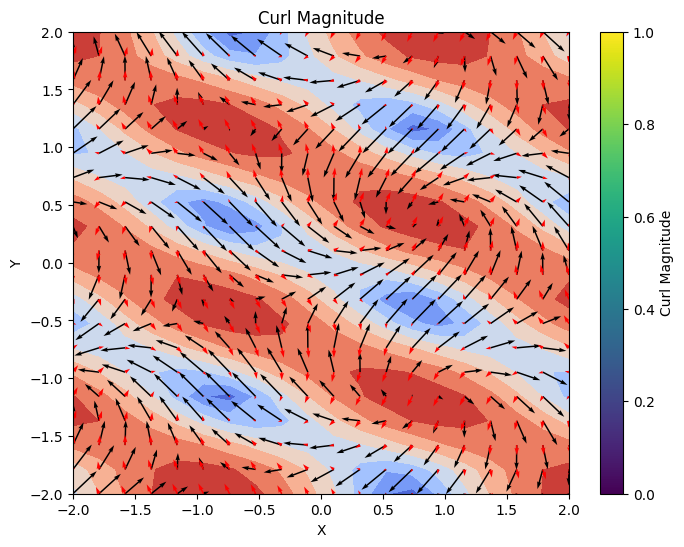

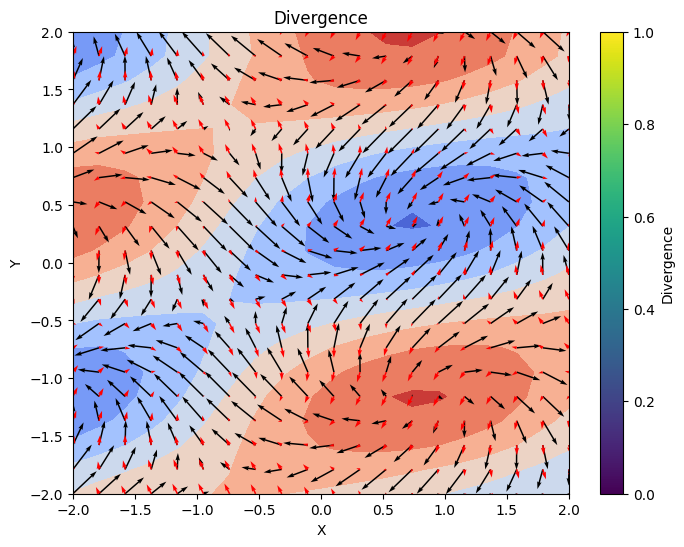

In [13]:
import numpy as np
import matplotlib.pyplot as plt


# Define the vector field function
def vector_field(x, y):
    Fx = np.cos(x + 2 * y)
    Fy = np.sin(x - 2 * y)
    return Fx, Fy


# Define the curl of the vector field
def curl(x, y):
    curl_x = np.gradient(vector_field(x, y)[1], axis=1)
    curl_y = -np.gradient(vector_field(x, y)[0], axis=0)
    return curl_x, curl_y


# Define the divergence of the vector field
def divergence(x, y):
    div_x = np.gradient(vector_field(x, y)[0], axis=1)
    div_y = np.gradient(vector_field(x, y)[1], axis=0)
    return div_x + div_y


# Generate 2D grid for visualization
x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)

# Plot vector field
plt.figure(figsize=(8, 6))


# Plot curl magnitude
curl_x, curl_y = curl(X, Y)
curl_mag = np.sqrt(curl_x**2 + curl_y**2)

plt.contourf(X, Y, curl_mag, cmap="coolwarm")
plt.quiver(X, Y, np.cos(X + 2 * Y), np.sin(X - 2 * Y), scale=20)
plt.quiver(X, Y, curl_x, curl_y, color="red", scale=20)
plt.colorbar(label="Curl Magnitude")
plt.title("Curl Magnitude")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()


# Plot vector field
plt.figure(figsize=(8, 6))


div = divergence(X, Y)

plt.contourf(X, Y, div, cmap="coolwarm")
plt.quiver(X, Y, np.cos(X + 2 * Y), np.sin(X - 2 * Y), scale=20)
plt.quiver(X, Y, curl_x, curl_y, color="red", scale=20)
plt.colorbar(label="Divergence")
plt.title("Divergence")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()